# Final Report: Movies and Their Ratings 
### Daniel Szyc, Dominic Imondi, Nolan Lemery, Jack Arseneau

-----------------------------------------------------------------------------------------------------

## Abstract

In order to find out what aspects of a film's data are correlated to the rating it recieves, we scraped the top 1000 and bottom 1000 rated movies from IMDB along with their runtime, box office gross, IMDb User votes, genres and other datapoints. In retrieving this data, we found that there was a slight positive relationship between the number of IMDb user votes and their rating. Using this information, we used numerical data points of the movies and fit the points to a multiple linear regression using user votes, runtime, gross, and genres with dummy variables to try and predict a movies rating. Using just the highest movies, the variance that could be explained by the model, or the $R^2$ value, was 39.3%. Using just the lowest movies the $R^2$ value was 8.7%. Using both the highest and the lowest, the $R^2$ was 54.5%. The most important features were the number of user votes, whether or not the film was a drama, the box office gross of the film, and the runtime. Unfortunately, we found that a lot of our assumptions of linear regression were not correct, as for several of the import x-features, the errors were not independent nor had constant variance, suggesting that there is another feature of the movies that we are not taking into account.

---------

## Introduction

##### When it comes to a movie, what aspects of its data are correlated to the rating it receives? 

As we can see on this [webpage](https://www.imdb.com/search/title/?groups=top_250&sort=user_rating), the IMDb list of the top 250 movies by user rating has an incredibly wide variety of films differing in genre, language, runtime, release year, and many other characteristics. Such a varying collection of films brings up the question of what attributes these high-rated films have most in common. Additionally, what about the lowest rated films? What do those have in common? What differences can we observe between the common characteristics of these disparately rated films?

##### To explore this inquiry, we can break our problem down into two questions:

- What attributes (genres, keywords in descriptions, runtimes, release years) appear more often in lower-rated movies?
- What attributes (genres, keywords in descriptions, runtimes, release years) appear more often in higher-rated movies?

By attempting to predict the rating of a film using common characteristics, we will be able to tell which are the most effective at predicting low rated movies and highly rated movies.

<font color='red'>i'll change this section later based on what ML stuff we choose to do</font>

----------

## Data Plan

Our project utilizes web scraping to access both the [top](https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&start=1&ref_=adv_nxt) and [bottom](https://www.imdb.com/search/title/?groups=bottom_1000&sort=user_rating,desc&start=1&ref_=adv_nxt) rated 1,000 movies on IMDb. From these two pages, we also retrieved all of the necessary data used to describe each movie.

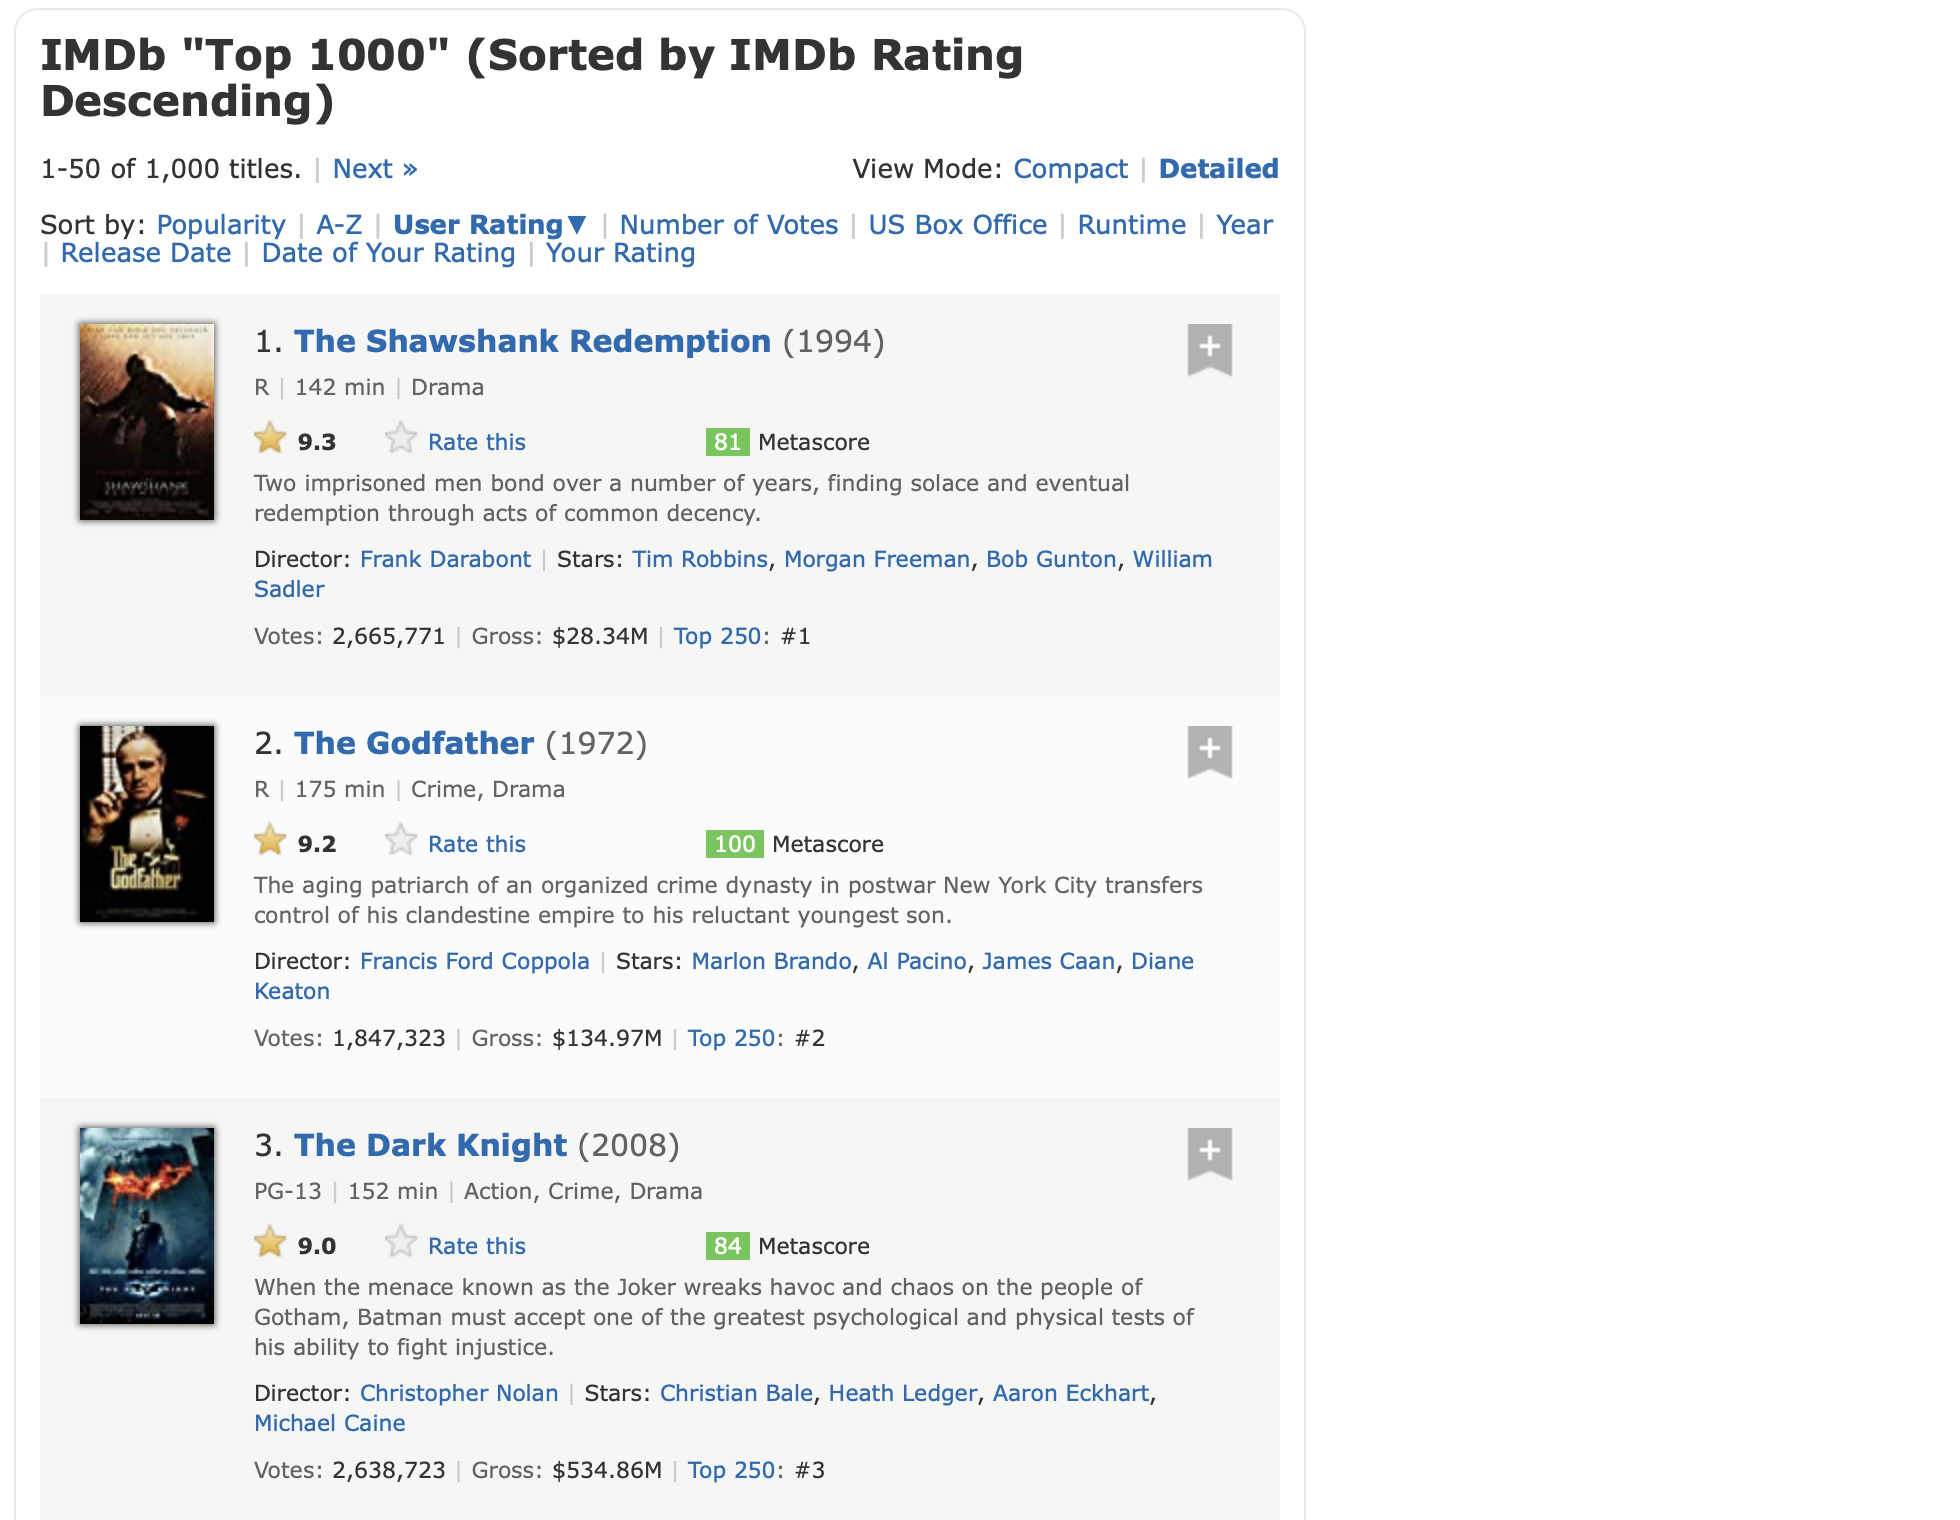

At the URL of each 1,000 film list, we gathered the film title, release year, rating, runtime, user votes, gross revenue, directors, stars, IMDb rating, and genres. This information, combined with slight alterations like separating genres into their own sections and converting runtimes to integers, formed our wholistic depiction of film data.

We were able to package this information into two seperate dataframes which we then combined into one dataframe that served as our data source for investigating the differences in film ratings. The below functions allowed us to accomplish this:

## Our Data Pipeline


#### The Webscraping Process

- `make_url()`
    - makes a url of a page of 50 movies given the page number and whether or not it is highest rated
- `rating_urls()`
    - finds the urls for all pages of all movies of the highest or lowest ratings
- `rating_soups()`
    - gets the soups for each page of highest or lowest rated movies
- `build_df()`
    - returns cleaned dataframe containing all movie information of highest 1000 or lowest 1000 movies

#### The Machine Learning Process

- `plot_feat_import`
    - plots the feature importance of a random forest regressor from a linear regression model as a bar chart

In [1]:
import requests 
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np

In [2]:
   def make_url(page_num, highest=True):
    ''' makes a url of a page of 50 movies given the page number and whether or not it is highest rated
    
    Args:
        page_num (int): the page number (0-19)
        highest (boolean): whether we get the highest rated movies or lowest rated
        
    Returns:
        url (str): the url to the page as a string
    '''
    insert_num = page_num * 50 + 1
        
    if (highest):
        url = f'https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&start={insert_num}&ref_=adv_nxt'
    else:
        url = f'https://www.imdb.com/search/title/?groups=bottom_1000&sort=user_rating,desc&start={insert_num}&ref_=adv_nxt'

    return url
    

In [3]:
def rating_urls(highest=True):
    ''' finds the urls for all pages of all movies of the highest or lowest ratings
    
    Args:
        highest (boolean): indicates if we are looking for highest rated or lowest rated movies
        
    Returns:
        urls (list of str): returns the urls for each page of 50 movies
    '''
    urls = []
    
    for idx in range(20):
        urls.append(make_url(idx, highest))  

    return urls


In [4]:
def rating_soups(highest=True):
    ''' gets the soups for each page of highest or lowest rated movies
    
    Args:
        highest (boolean): indicates if we are looking for highest rated or lowest rated movies
        
    Returns:
        soups (list of BeautifulSoup): the list of soups corresponding to each page of 50 movies    
    '''
    urls = rating_urls(highest)
    soups = []
    
    for url in urls:
        str_html = requests.get(url).text
        soup = BeautifulSoup(str_html)
        soups.append(soup)
    
    return soups
    

In [5]:
def build_df(highest=True):
    ''' builds and cleans the data frame over the top or bottom 1000 movies
    
    Args:
        highest (boolean): indicates if we are looking for highest rated or lowest rated movies
        
    Returns:
        df_movies (DataFrame): the data frame of all the movies' data
    '''
    # get the soups for the pages
    soups = rating_soups(highest)
    
    # initialize all the lists that will store the data
    titles = []
    release_years = []
    ratings = []
    runtimes = []
    votes = []
    grossed = []
    directors = []
    stars = []
    star_ratings = []
    # initialize genre lists:
    action = []
    adventure = []
    biography = []
    comedy = []
    crime = []
    drama = []
    family = []
    fantasy = []
    history = []
    horror = []
    mystery = []
    romance = []
    sci_fi = []
    thriller = []
    war = []
    western = []
    music = []
    musical = []
    sport = []
    film_noir = []
    animation = []
    # all genres:
    genre_list = ['Action','Adventure','Biography','Comedy','Crime','Drama','Family','Fantasy','History',
                  'Horror','Mystery','Romance','Sci-Fi','Thriller','War','Western','Music','Musical','Sport',
                  'Film-Noir','Animation']
    
    # loop through every list of 50 movies in the list
    for soup in soups:
        # find every movie item on the page
        movies = soup.find_all(class_="lister-item mode-advanced")
        # loop through each movie
        for movie in movies:
            # append the relevant data
            titles.append(movie.find('h3', class_='lister-item-header').text.split('\n')[2])
            release_years.append(int(movie.find('span', class_='lister-item-year text-muted unbold')\
                                 .text.replace('(', '').replace(')', '')\
                                 .replace("I", "").replace(" ", "").replace("V", "")))
            rating = movie.find('span', class_='certificate')
            # some movies do not have MPAA ratings
            if rating:
                ratings.append(rating.text)
            else:
                ratings.append(np.nan)
            runtimes.append(int(movie.find('span', class_='runtime').text.strip().replace(" min", "")))
            votes.append(int(movie.find('p', class_='sort-num_votes-visible').text.split("\n")[2].replace(",", "")))
            gross = movie.find('p', class_='sort-num_votes-visible').text.split('\n')
            # some movies to not have gross data
            if len(gross) >= 5:
                grossed.append(float(gross[4].replace("$", "").replace("M", "").replace("#", "")))
            else:
                grossed.append(np.nan)
            directors.append(movie.find('p', class_='').text.split("Stars:")[0].split("\n")[2])
            stars.append(movie.find('p', class_='').text.split("Stars:")[1].replace("\n", ""))
            star_ratings.append(float(movie.find('div', \
                                           class_="inline-block ratings-imdb-rating").text.replace("\n", "")))
            # append to genre columns
            genre = movie.find('span', class_='genre').text.strip()
            genre_bools = []
            for g in genre_list:
                if g in genre:
                    genre_bools.append(1)
                else:
                    genre_bools.append(0)
            action.append(genre_bools[0])
            adventure.append(genre_bools[1])
            biography.append(genre_bools[2])
            comedy.append(genre_bools[3])
            crime.append(genre_bools[4])
            drama.append(genre_bools[5])
            family.append(genre_bools[6])
            fantasy.append(genre_bools[7])
            history.append(genre_bools[8])
            horror.append(genre_bools[9])
            mystery.append(genre_bools[10])
            romance.append(genre_bools[11])
            sci_fi.append(genre_bools[12])
            thriller.append(genre_bools[13])
            war.append(genre_bools[14])
            western.append(genre_bools[15])
            music.append(genre_bools[16])
            musical.append(genre_bools[17])
            sport.append(genre_bools[18])
            film_noir.append(genre_bools[19])
            animation.append(genre_bools[20])
            
    # add all data to the dataframe
    movies_dict = {}
    movies_dict["Titles"] = titles
    movies_dict["Release Years"] = release_years
    movies_dict["Ratings"] = ratings
    movies_dict["Runtimes (in minutes)"] = runtimes
    movies_dict["User Votes"] = votes
    movies_dict["Grossed (in millions USD)"] = grossed
    movies_dict["Directors"] = directors
    movies_dict["Stars"] = stars
    movies_dict["IMDB Rating"] = star_ratings
    movies_dict["Action"] = action
    movies_dict["Adventure"] = adventure
    movies_dict["Biography"] = biography
    movies_dict["Comedy"] = comedy
    movies_dict["Crime"] = crime
    movies_dict["Drama"] = drama
    movies_dict["Family"] = family
    movies_dict["Fantasy"] = fantasy
    movies_dict["History"] = history
    movies_dict["Horror"] = horror
    movies_dict["Mystery"] = mystery
    movies_dict["Romance"] = romance
    movies_dict["Sci-fi"] = sci_fi
    movies_dict["Thriller"] = thriller
    movies_dict["War"] = war
    movies_dict["Western"] = western
    movies_dict["Music"] = music
    movies_dict["Musical"] = musical
    movies_dict["Sport"] = sport
    movies_dict["Film-Noir"] = film_noir
    movies_dict["Animation"] = animation

    df_movies = pd.DataFrame(movies_dict)
    
    return df_movies
    

In [6]:
true_df = build_df()
true_df.head()

Titles  Release Years Ratings  \
0                       The Shawshank Redemption           1994       R   
1                                  The Godfather           1972       R   
2                                The Dark Knight           2008   PG-13   
3  The Lord of the Rings: The Return of the King           2003   PG-13   
4                               Schindler's List           1993       R   

   Runtimes (in minutes)  User Votes  Grossed (in millions USD)  \
0                    142     2666407                      28.34   
1                    175     1847727                     134.97   
2                    152     2639319                     534.86   
3                    201     1838093                     377.85   
4                    195     1350072                      96.90   

              Directors                                              Stars  \
0        Frank Darabont  Tim Robbins, Morgan Freeman, Bob Gunton, Willi...   
1  Francis Ford Coppola  Marlon Brando, Al Pacino, James Caan, Diane Ke...   
2     Christopher Nolan  Christian Bale, Heath Ledger, Aaron Eckhart, M...   
3         Peter Jackson  Elijah Wood, Viggo Mortensen, Ian McKellen, Or...   
4      Steven Spielberg  Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...   

   IMDB Rating  Action  ...  Romance  Sci-fi  Thriller  War  Western  Music  \
0          9.3       0  ...        0       0         0    0        0      0   
1          9.2       0  ...        0       0         0    0        0      0   
2          9.0       1  ...        0       0         0    0        0      0   
3          9.0       1  ...        0       0         0    0        0      0   
4          9.0       0  ...        0       0         0    0        0      0   

   Musical  Sport  Film-Noir  Animation  
0        0      0          0          0  
1        0      0          0          0  
2        0      0          0          0  
3        0      0          0          0  
4        0      0          0          0  

[5 rows x 30 columns]

In [7]:
false_df = build_df(False)
false_df.head()

Titles  Release Years    Ratings  \
0                              Kick           2014  Not Rated   
1                      Sooryavanshi           2021        NaN   
2                 Samrat Prithviraj           2022        NaN   
3                         Beta Test           2016  Not Rated   
4  Resident Evil: The Final Chapter           2016          R   

   Runtimes (in minutes)  User Votes  Grossed (in millions USD)  \
0                    146       68450                       2.46   
1                    145       77033                        NaN   
2                    135       52777                        NaN   
3                     88       19861                       0.01   
4                    107       95090                      26.83   

                 Directors                                              Stars  \
0         Sajid Nadiadwala  Salman Khan, Jacqueline Fernandez, Nawazuddin ...   
1             Rohit Shetty  Akshay Kumar, Katrina Kaif, Ajay Devgn, Ranvee...   
2  Chandra Prakash Dwivedi  Akshay Kumar, Manav Vij, Sanjay Dutt, Ashutosh...   
3          Nicholas Gyeney  Manu Bennett, Larenz Tate, Linden Ashby, Kevon...   
4       Paul W.S. Anderson  Milla Jovovich, Iain Glen, Ali Larter, Shawn R...   

   IMDB Rating  Action  ...  Romance  Sci-fi  Thriller  War  Western  Music  \
0          6.2       1  ...        0       0         0    0        0      0   
1          6.1       1  ...        0       0         1    0        0      0   
2          5.9       1  ...        0       0         0    0        0      0   
3          5.6       1  ...        0       1         1    0        0      0   
4          5.5       1  ...        0       1         0    0        0      0   

   Musical  Sport  Film-Noir  Animation  
0        0      0          0          0  
1        0      0          0          0  
2        0      0          0          0  
3        0      0          0          0  
4        0      0          0          0  

[5 rows x 30 columns]

## Data Visualization

In [8]:
import plotly.express as px

px.scatter(data_frame=true_df, y="IMDB Rating", x="User Votes", hover_data=["Titles"], title="IMDb Rating vs. User Votes - Top Rated Movies").show()

In [9]:
px.scatter(data_frame=false_df, y="IMDB Rating", x="User Votes", hover_data=["Titles"], title="IMDb Rating vs. User Votes - Low Rated Movies").show()

The above scatterplots show the relationship between user votes and IMDb rating. Despite being a bit messy, we can see a slight positive correlation in both graphs, though particularly in the first graph. As user votes increase, the number of movies decreases by a lot, and we can see that the vast majority of movies from the data are rated between 4 and 9. We can also note that the User Votes are on average much greater in the top-rated movies graph than in the low-rated movies graph.

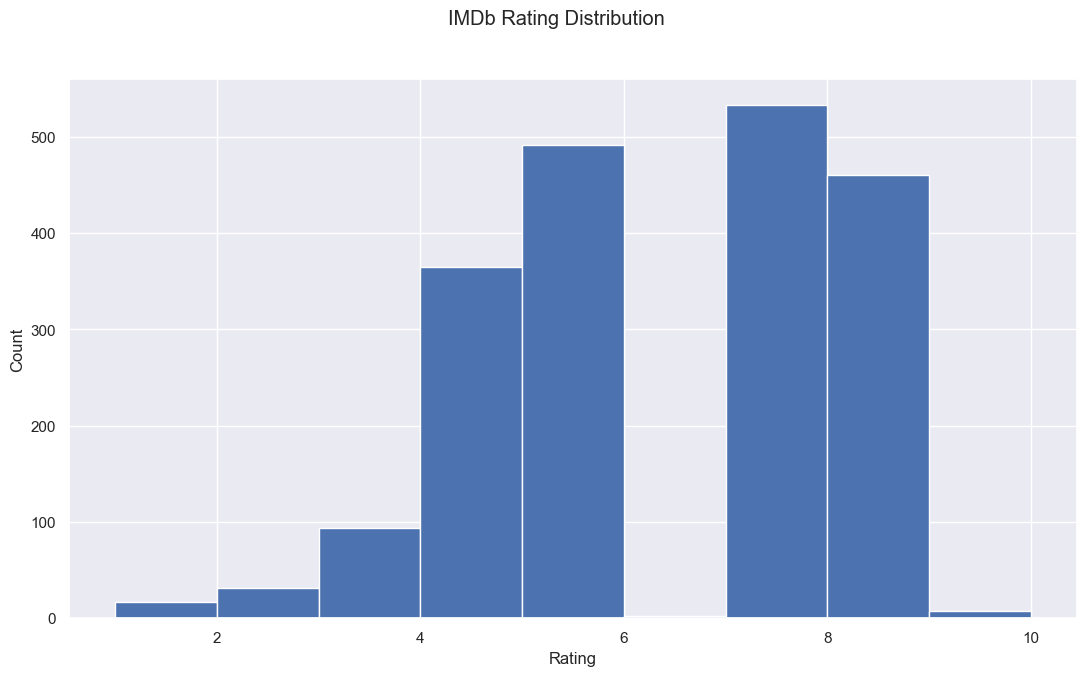

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

total_df = pd.concat([true_df, false_df])

bins = np.linspace(0, 10, 10)

plt.hist(total_df['IMDB Rating'], bins=[1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.suptitle("IMDb Rating Distribution")

plt.gcf().set_size_inches(13, 7)

This histogram shows the amount of IMDb ratings for the top 1000 and bottom 1000 movies, using scores of 1-2, 2-3, 3-4, ..., 9-10 as bins. We can see that most of the movies are rated between 4 and 9, and very few exceed or fall below that range. The gap in the middle makes sense, as our data only consists of the 1000 highest rated movies and 1000 lowest rated movies. This is a pitfall in the data we collected, and will have some repercussions in the machine learning phase of this project.

--------

## Method

## Machine Learning

### Multiple Regression

The machine learning method we chose was Multiple Regression, and we will use a Random Forest Regressor to check feature importance.

Using Multiple Regression, we will create three models that predict a movie's IMDb Rating based on its runtime, user votes, amount of money grossed, and genre. One model will be for the top-rated movies, one will be for the low-rated movies, and one will be for all of them together. Our goal with these models is to see how accurately the listed movie features indicate an IMDb movie rating, by means of multiple regression. 

What Multiple Regression does, essentially, is create a function of a y feature in terms of multiple x features, such that when given the x features, the y feature can be predicted. It uses Linear Regression to do this. The model (where $x_i$ refer to distinct features) is given below:

$$
y = b_0\cdot x_0 + b_1 \cdot x_1 + b_2 \cdot x_2 + ... + b_n \cdot x_n
$$

In the model we are making, y is the IMDb Rating, and the x features are runtime, user votes, amount of money grossed, and genres (1 or 0 boolean values).

An assumption we make by using this model is that the 2000 movies we are using represent a large enough data set to warrant accurate predictions, and that the data from IMDb is trustworthy. Another assumption we are making is that the relationship between a movie's IMDb rating and the other x features justifies a linear relationship model, as opposed to a non-linear polynomial one.

This method is sound in this context because we feel an IMDb rating is more suitable as a numerical feature than a categorical one. Additionally, we think that there are multiple, sufficiently significant numerical features to be used to predict an IMDb rating. We believe that Multiple Regression is the best regression variant to use here because we desire a model that will use multiple x features in a prediction of the IMDb rating, as we believe there are multiple features that are important in making that prediction.

Some pitfalls of this method include, as stated above in one of the assumptions we are making, we are relying on the linear relationship between these features and IMDb rating, as opposed to a non-linear polynomial one. For features that might better be represented with a non-linear relationship with IMDb rating, they will not be as useful in our model as they could be in another.

Using a Random Forest Regressor, which seeks to minimize the Mean of Squared Error (MSE) at each node, we will see what features from our models are most and least important in predicting the rating of movies in the low rated data set, high rated data set, and the total data set. In other words, we will determine what features are most vital in predicting a movie's IMDb rating in more specific models (high and low rated), as well as a broader one (total).

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import pylab as py
import scipy.stats as stats

In [12]:
def make_feat_list(movie_df):
    '''
    Makes the numeric x feature list for this dataframe
    Args:
        movie_df (Dataframe): A dataframe of movies used to predict IMDB rating
    Returns:
        x_feat_list (list): the list of x features for the machine learning algo
    '''
    # prepare the x_feat_list
    x_feat_list = list(true_df.columns)
    # remove all non-numeric points and y-feat
    x_feat_list.remove('Titles')
    x_feat_list.remove('Release Years')
    x_feat_list.remove('Ratings')
    x_feat_list.remove('Directors')
    x_feat_list.remove('Stars')
    x_feat_list.remove('IMDB Rating')
    
    return x_feat_list

In [13]:
def find_eq_and_r2(movie_df):
    '''
    Finds the coefficients for a multiple linear regression using the given movie dataframe.
    Args:
        x_feat_list (list): a list of the x features
        movie_df (Dataframe): A dataframe of movies used to predict IMDB rating
    Returns:
        eq_and_r2 (str): A string that contains the equation for the multiple regression and
        the r2 value.
    '''
    eq_and_r2 = ''
    
    x_feat_list = make_feat_list(movie_df)
    
    movie_df = movie_df.dropna(subset=x_feat_list)
    
    # we want the y feature to be the IMDB rating
    y_feat = 'IMDB Rating'
    
    # initialize the x and y values
    x = np.array(movie_df.loc[:,x_feat_list].values)
    y = np.array(movie_df['IMDB Rating'])

    # initialize sklearn model
    reg = LinearRegression()

    # fit the model
    reg.fit(x, y)
    
    y_pred = reg.predict(x)
    
    # find the r2 of the model
    r2 = r2_score(y_true=y, y_pred=y_pred)
    eq_and_r2 += f'r2 = {r2:.3}\n'

    # create a string of the equation with coefficients
    model_str = y_feat + f' = {reg.intercept_:.2f}'
    for feat, coef in zip(x_feat_list, reg.coef_):
        model_str += f' + {coef:.4f} {feat}'
    eq_and_r2 += model_str
    
    # return the equation and r2 values
    return eq_and_r2

In [14]:
total_df = pd.concat([true_df, false_df])

In [15]:
print("Top 1000 Model:")
print(find_eq_and_r2(true_df))
print("-----------------")
print("Bottom 1000 Model:")
print(find_eq_and_r2(false_df))
print("-----------------")
print("Combined Model:")
print(find_eq_and_r2(total_df))

Top 1000 Model:
r2 = 0.393
IMDB Rating = 7.69 + 0.0016 Runtimes (in minutes) + 0.0000 User Votes + -0.0005 Grossed (in millions USD) + -0.0541 Action + -0.0199 Adventure + -0.0355 Biography + -0.0468 Comedy + -0.0328 Crime + 0.0035 Drama + 0.0040 Family + -0.0684 Fantasy + -0.0533 History + -0.0872 Horror + 0.0048 Mystery + -0.0064 Romance + -0.0828 Sci-fi + -0.0709 Thriller + 0.1073 War + 0.0609 Western + -0.0076 Music + 0.0175 Musical + -0.0046 Sport + 0.1558 Film-Noir + 0.0486 Animation
-----------------
Bottom 1000 Model:
r2 = 0.0866
IMDB Rating = 4.49 + 0.0001 Runtimes (in minutes) + 0.0000 User Votes + 0.0013 Grossed (in millions USD) + 0.0976 Action + -0.1077 Adventure + -0.4078 Biography + 0.0612 Comedy + -0.0311 Crime + 0.2443 Drama + -0.0683 Family + -0.0436 Fantasy + 0.6389 History + 0.0705 Horror + 0.1398 Mystery + 0.0706 Romance + -0.1145 Sci-fi + 0.0723 Thriller + -0.2686 War + 0.4355 Western + -0.7095 Music + 0.3486 Musical + -0.4431 Sport + 0.0000 Film-Noir + 0.2243 Ani

### Testing

Testing our models on a movie not included in our data:

In [16]:
# "The Santa Clause" (1994) starring Tim Allen:
sc_x = [[97, 117964, 144.83, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
sc_rating_actual = 6.5

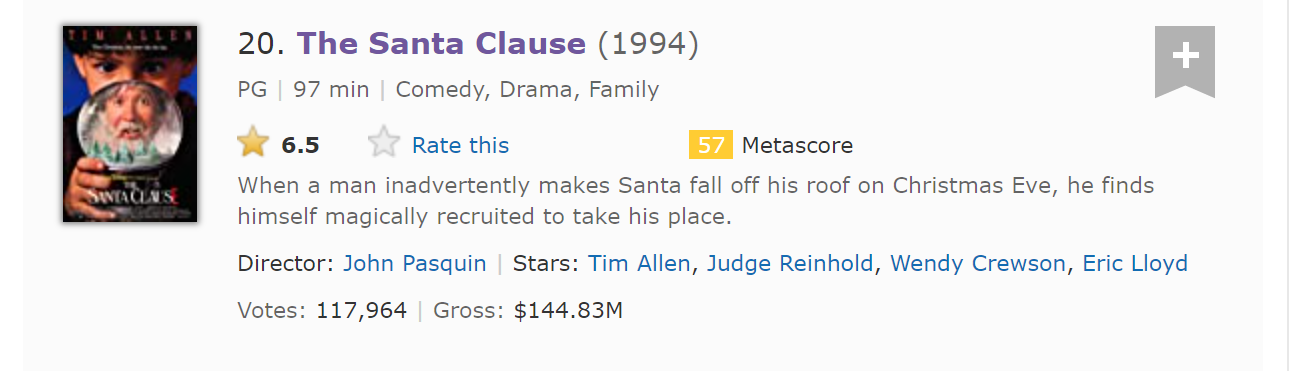

In [17]:
def predict(movie_df, to_predict):
    
    x_feat_list = make_feat_list(movie_df)
    
    movie_df = movie_df.dropna(subset=x_feat_list)
    
    x = np.array(movie_df.loc[:,x_feat_list].values)
    y = np.array(movie_df['IMDB Rating'])

    # initialize sklearn model
    reg = LinearRegression()

    # fit the model
    reg.fit(x, y)

    pred = reg.predict(to_predict)
    
    return pred[0]

In [18]:
print(f"Top rated model prediction of 'The Santa Clause': {predict(true_df, sc_x)}")
print(f"Low rated model prediction of 'The Santa Clause': {predict(false_df, sc_x)}")
print(f"Combined model prediction of 'The Santa Clause': {predict(total_df, sc_x)}")
print(f"Actual rating of 'The Santa Clause': {sc_rating_actual}")

Top rated model prediction of 'The Santa Clause': 7.778339713833956
Low rated model prediction of 'The Santa Clause': 5.156904649622745
Combined model prediction of 'The Santa Clause': 6.152681536985161
Actual rating of 'The Santa Clause': 6.5


### Random Forest Regressor

In [19]:
import matplotlib.pyplot as plt

def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.title('Feature importance\n(Mean decrease in MSE across all Decision Trees)')

In [20]:
def get_feat_importance(movie_df):
    '''
    Uses a random forest regressor to identify the 
    importance of features for predicting rating. Plots feature importance
    and prints r2 value of random forest regressor
    Args:
        movie_df (Dataframe): A dataframe of movies used to predict IMDB rating
    '''
    y_feat = 'IMDB Rating'
    x_feat_list = make_feat_list(movie_df)
    
    movie_df = movie_df.dropna(subset=x_feat_list)
    
    # initialize regression object
    rand_forest_regressor = RandomForestRegressor()

    # get target variable
    x = movie_df.loc[:, x_feat_list].values
    y = movie_df.loc[:, y_feat].values

    # fit regression
    rand_forest_regressor.fit(x, y)

    # compute / store r2
    y_pred = rand_forest_regressor.predict(x)
    
    # compute r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    print(f'r2 = {r2:.3}')
    
    plot_feat_import(x_feat_list, rand_forest_regressor.feature_importances_)

r2 = 0.922


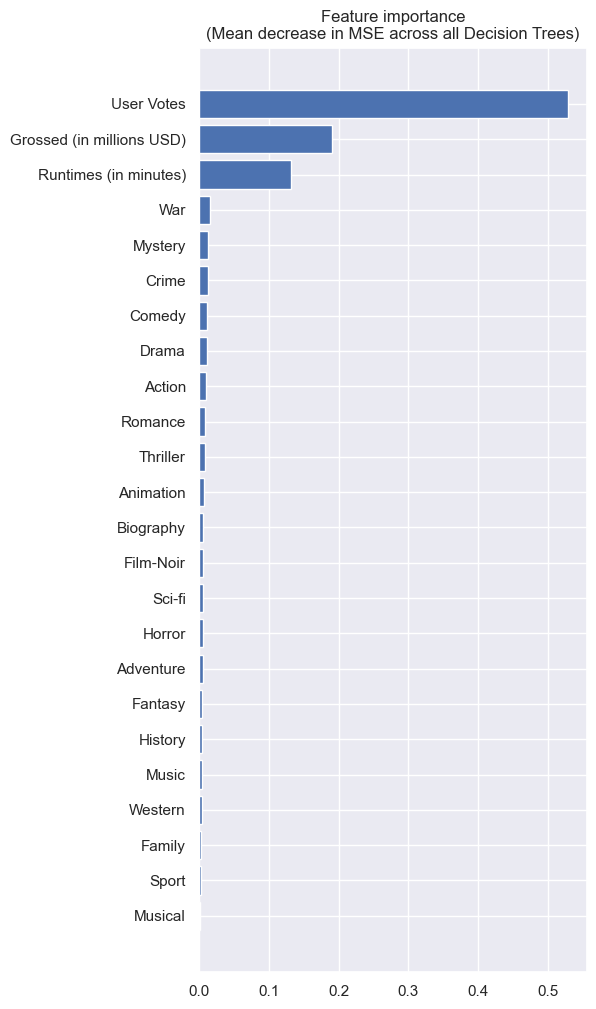

In [21]:
get_feat_importance(true_df)

r2 = 0.85


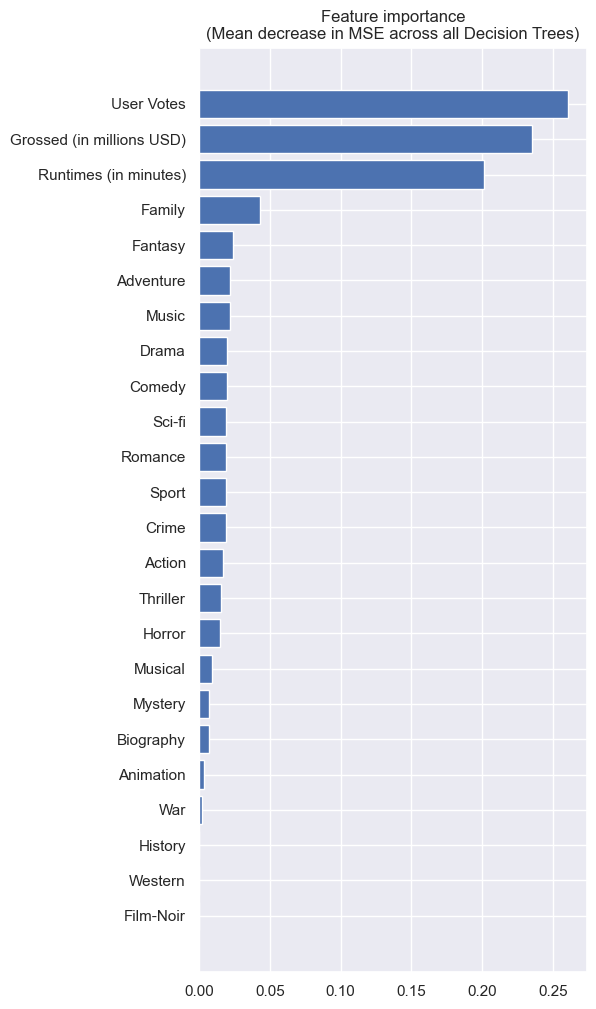

In [22]:
get_feat_importance(false_df)

r2 = 0.966


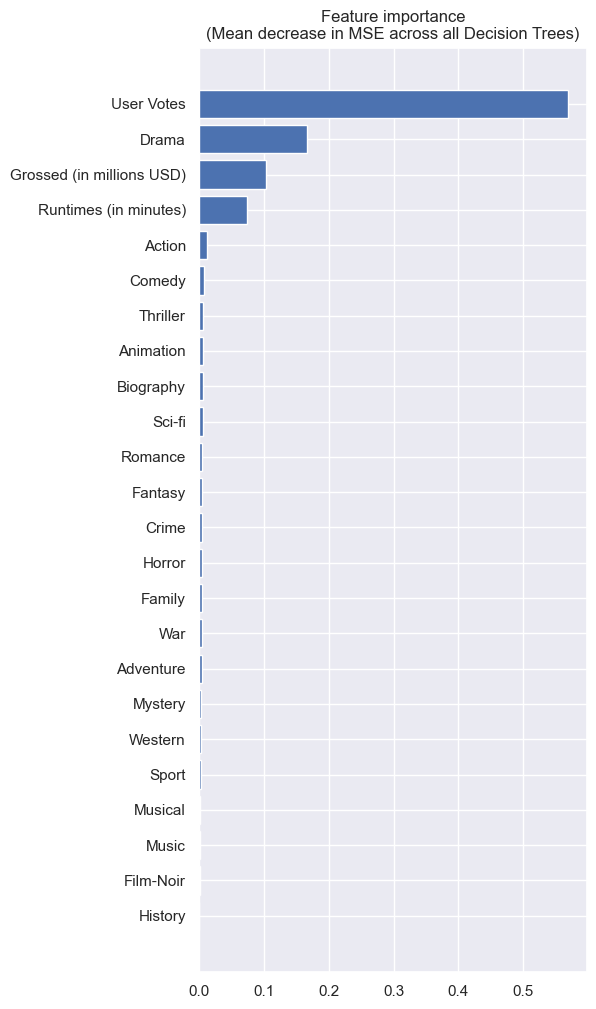

In [23]:
get_feat_importance(total_df)

### Multiple Regression Assumption Checking

In [24]:
def check_independence(movie_df, descriptor="movie dataframe"):
    '''
    Checks assumption of independence for linear regression
    Args:
        movie_df (Dataframe): A dataframe of movies used to predict IMDB rating
        descriptor (str): A string specifying what movies this dataframe represents
    '''
    # initialize regression object
    reg = LinearRegression()

    x_feat_list = make_feat_list(movie_df)
    y_feat = 'IMDB Rating'
    
    movie_df = movie_df.dropna(subset=x_feat_list)

    # get target variable
    x = movie_df.loc[:, x_feat_list].values
    y = movie_df.loc[:, y_feat].values

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)
    
    # check independence
    errors = y - y_pred
    plt.scatter(x = range(len(y)), y = errors)
    plt.xlabel('index')
    plt.ylabel('errors');
    plt.suptitle(f'independence checking - {descriptor}')

In [25]:
def check_constant_variance(movie_df, x_feat, descriptor="movie dataframe"):
    '''
    Checks assumptions of constant variance for the specified x feature
    Args:
        movie_df (Dataframe): A dataframe of movies used to predict IMDB rating
        x_feat (str): the x feature being tested
        descriptor (str): A string specifying what movies this dataframe represents
    '''
    # initialize regression object
    reg = LinearRegression()

    x_feat_list = make_feat_list(movie_df)
    y_feat = 'IMDB Rating'
    
    movie_df = movie_df.dropna(subset=x_feat_list)

    # get target variable
    x = movie_df.loc[:, x_feat_list].values
    y = movie_df.loc[:, y_feat].values

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)
    
    # check independence
    errors = y - y_pred
    plt.scatter(x = movie_df[x_feat], y = errors)
    plt.xlabel(x_feat)
    plt.ylabel('errors');
    plt.suptitle(f'constant variance ({x_feat}) checking - {descriptor}')

In [26]:
def check_normalized(movie_df, descriptor='movie dataframe'):
    '''
    Checks assumptions of normalized errors
    Args:
        movie_df (Dataframe): A dataframe of movies used to predict IMDB rating
        descriptor (str): A string specifying what movies this dataframe represents
    '''
    # initialize regression object
    reg = LinearRegression()

    x_feat_list = make_feat_list(movie_df)
    y_feat = 'IMDB Rating'
    
    movie_df = movie_df.dropna(subset=x_feat_list)

    # get target variable
    x = movie_df.loc[:, x_feat_list].values
    y = movie_df.loc[:, y_feat].values

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)
    
    # check independence
    errors = y - y_pred
    stats.probplot(errors.reshape((-1,)), dist="norm", plot=py)
    py.show()

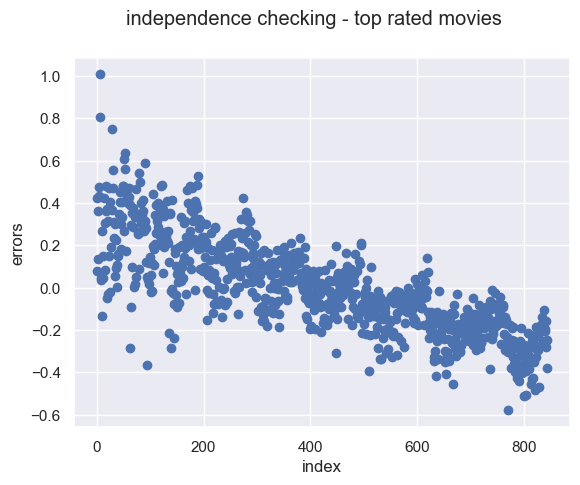

In [27]:
check_independence(true_df, descriptor='top rated movies')

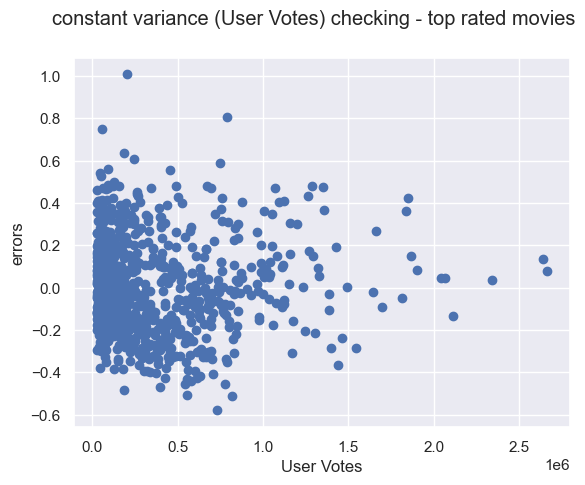

In [28]:
check_constant_variance(true_df, 'User Votes', 'top rated movies')

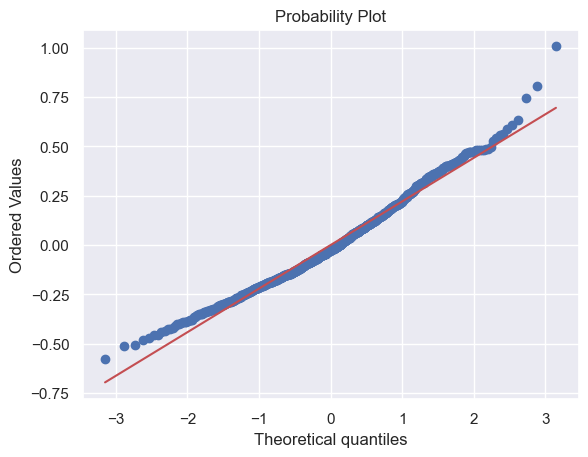

In [29]:
check_normalized(true_df, 'top rated movies')

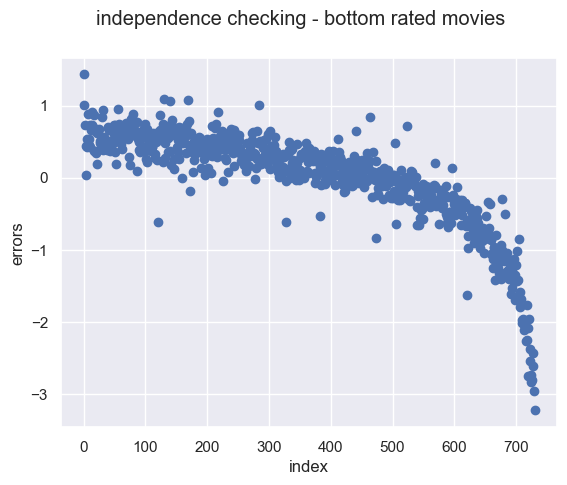

In [30]:
check_independence(false_df, descriptor='bottom rated movies')

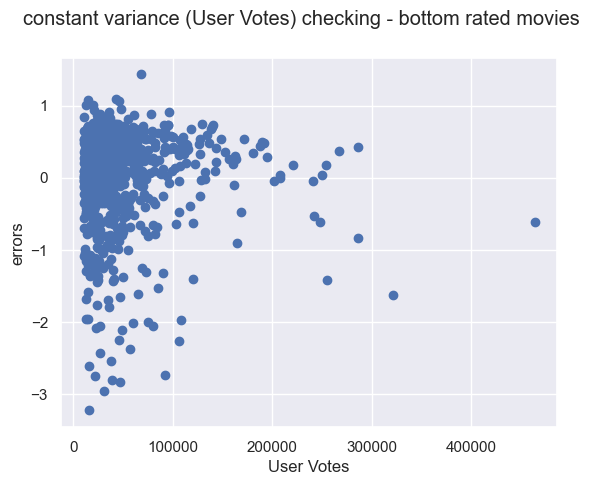

In [31]:
check_constant_variance(false_df, 'User Votes', descriptor='bottom rated movies')

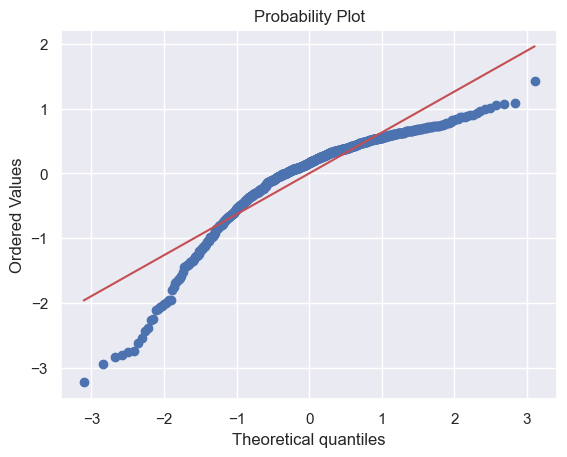

In [32]:
check_normalized(false_df, 'bottom rated movies')

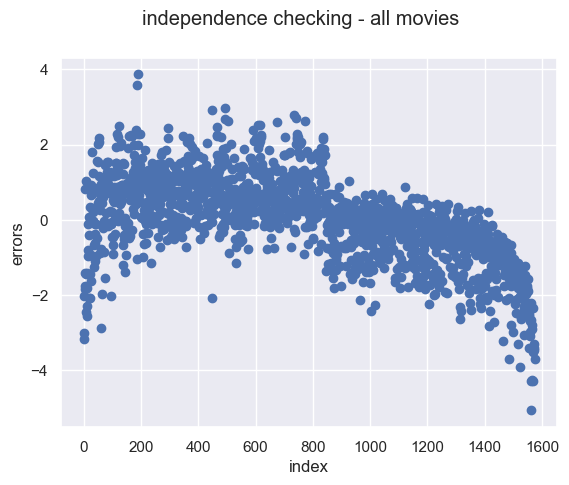

In [33]:
check_independence(total_df, 'all movies')

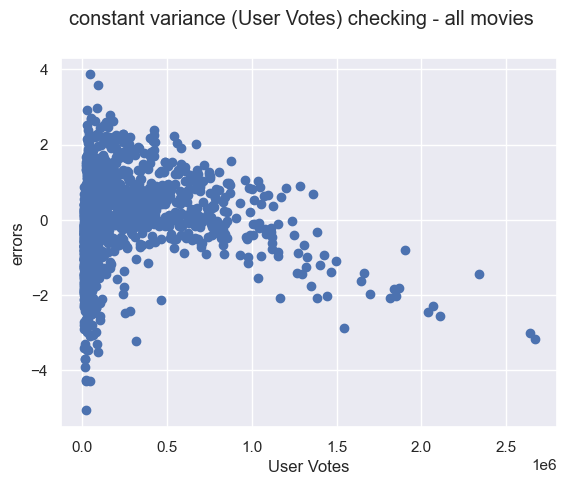

In [34]:
check_constant_variance(total_df, 'User Votes', 'all movies')

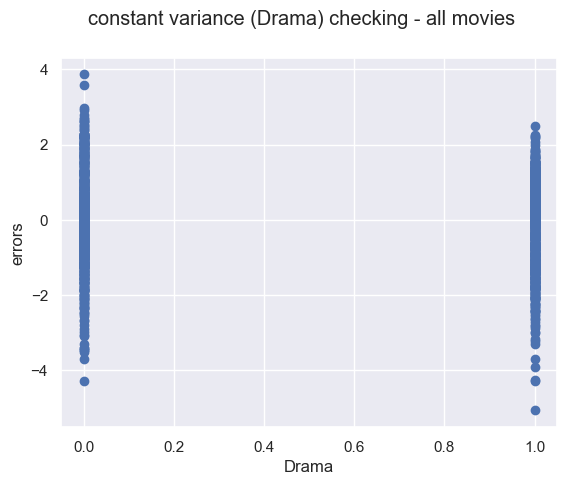

In [35]:
check_constant_variance(total_df, 'Drama', 'all movies')

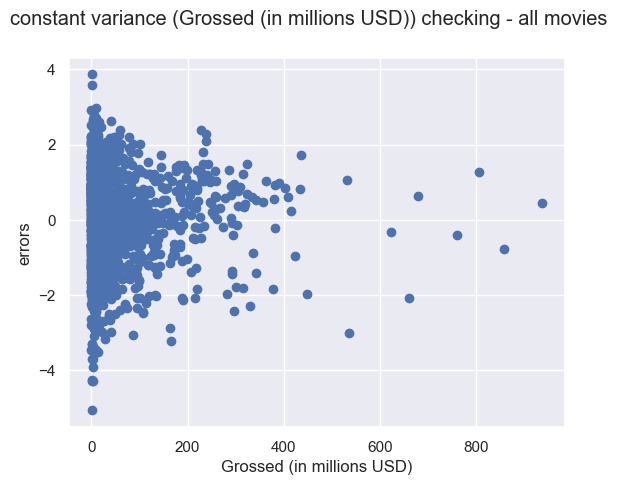

In [36]:
check_constant_variance(total_df, 'Grossed (in millions USD)', 'all movies')

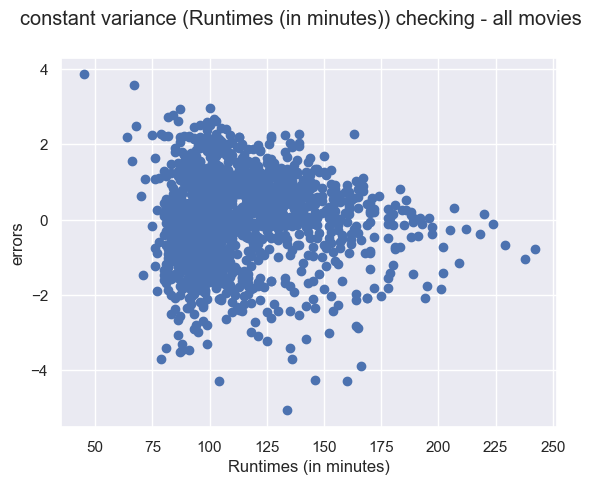

In [37]:
check_constant_variance(total_df, 'Runtimes (in minutes)', 'all movies')

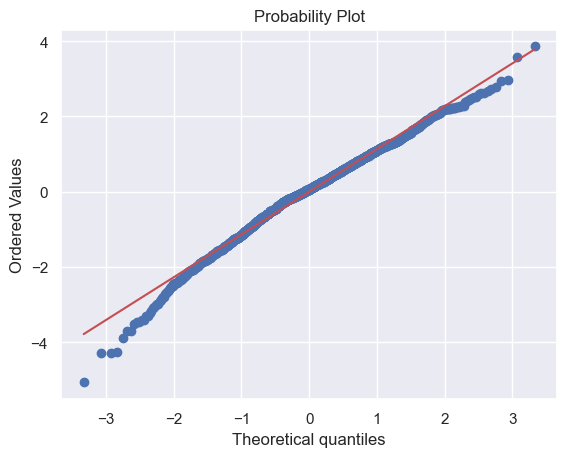

In [38]:
check_normalized(total_df, 'all movies')

## Discussion

- We answered our original questions with the help of a random forest regressor, in addition to creating models that can can help predict movie ratings 
    - We trained multiple linear regression on the highest rated movies, the lowest rated movies, and the combined data set. We found that the number of user votes was always the most important feature. 
        - In the model trained on the data set of the lowest rated movies, we found that the amount of dollars and runtime followed closely in importance.
        - In the other two models, there was a steeper drop in importance, though the order of importance was maintained.
- Besides checking independence and a normal distribution of errors, we made sure to check the most important x features for constant variance/linearity. We found that the data generally met the assumptions, with the exception of independence, where an observable trend was present, indicating some dependency between data points. Therefore, results from this model may be slightly innacurate.
- As data scientiests, we don't need to take any action as a result of this analysis, but movie producers might find the findings useful in guaging how well theoretical movies might do in terms of IMDB ratings
- Some unanticipated questions that arose as we worked on the project:
    - Is the relationship between data linear/exponential/polynomial
        - This question was necessary to determine the type of regression to use, and after some experimenting we settled on a linear regression model.
    - Should multiple features be considered?
        - Once we settled on linear regression, we had to decide whether to use multiple movie features to predict the rating. While a single feature linear regression could have aligned with the assumtions better, we decided that multiple regression was best to capture the full scope of a movie's characteristics.
- Future work/analyses
    - One feature of movies that we failed to include was directors and cast. Doing so would go beyond the scope of the course, in the sense that we've only seen regression with numeric data, but in the real world the actors and director behind a movie can have a significant impact on that movie's rating.